# Conclusion

This project consisted of using 5 different approaches to classify the digits of the MNIST dataset:

1. Naive Bayes
2. K-Nearest Neighbors
3. Linear Classifier
4. Multi-Layer Perceptron
5. Convolutional Neural Network


Although I've learned much from this project, I plan on digging deeper and explore more methods of optimization and evaluation.
One of the first things that I want to do is to obtain a higher accuracy both on the training data and test data for all models. For naive bayes, for example, I think the most promising thing to try would be to not binarize the images and instead have about 4 or 5 values a pixel can take on depending on a threshold. Another approach that might yield some results is to not assume independence, although this might be the most complicated to implement. 

In the case of the neural networks, one thing that remains is how to find the best hyperparameters not only to reach a good minimum but to reach it fast.
An approach that would be fantastic to implement would be a function that can generate the result of different combinations of hyperparameters something like cross validation grid search and use these results to plot graphs. Specifically, I'm interested in contour plots that would show how the path from the starting point changes with different step sizes and momentums as shown in this plot,

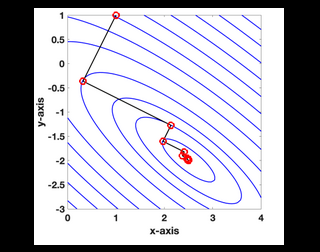

Image source: Wikipedia

ChatGPT generated the following code to plot these contour plots, however it is not properly working at the moment.



In [ ]:
# ...existing code...
# Add the following cell to run a momentum vs learning-rate grid and make contour plots.

import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_run(momentum, lr, epochs=14, bs=128, subset=x_train.size(0), verbose=False):
    # reinitialize model & optimizer so each combo starts fresh
    torch.manual_seed(0)
    model = ConvNet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    model.train()

    # use a subset for speed
    n_samples = min(subset, x_train.size(0))
    X = x_train[:n_samples].to(device)
    Y = y_train[:n_samples].to(device)

    n_batches = (n_samples - 1)//bs + 1
    last_epoch_loss = None
    for ep in range(epochs):
        running_loss = 0.0
        for i in range(n_batches):
            start = i*bs
            end = start+bs
            imgs = X[start:end]
            labs = Y[start:end]

            optimizer.zero_grad()
            outs = model(imgs)
            loss = criterion(outs, labs)
            # detect immediate NaN/divergence
            if torch.isnan(loss) or loss.item() > 1e3:
                return np.nan, np.nan  # flag divergent
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        last_epoch_loss = running_loss / n_batches
        if verbose:
            print(f"m={momentum:.3f} lr={lr:.1e} ep={ep+1} loss={last_epoch_loss:.4f}")
    # compute test accuracy on small validation subset
    model.eval()
    with torch.no_grad():
        Xval = x_test[:2000].to(device)
        Yval = y_test[:2000].to(device)
        outs = model(Xval)
        preds = outs.argmax(dim=1)
        acc = (preds == Yval).float().mean().item()
    return last_epoch_loss, acc

def sweep(momentums, lrs, epochs=5, bs=128, subset=5000):
    loss_grid = np.zeros((len(lrs), len(momentums)))
    acc_grid = np.zeros_like(loss_grid)
    start = time.time()
    for i, lr in enumerate(lrs):
        for j, m in enumerate(momentums):
            loss, acc = train_one_run(momentum=m, lr=lr, epochs=epochs, bs=bs, subset=subset)
            loss_grid[i,j] = np.nan if np.isnan(loss) else loss
            acc_grid[i,j] = np.nan if np.isnan(acc) else acc
    print("Sweep done in {:.1f}s".format(time.time()-start))
    return loss_grid, acc_grid

# choose grid (adjust ranges / density for runtime)
momentums = np.linspace(0.0, 0.99, 11)            # 11 momentum values
lrs = np.logspace(-4, -1, 10)                     # lr from 1e-4 to 1e-1

loss_grid, acc_grid = sweep(momentums, lrs, epochs=5, bs=128, subset=5000)

# contour plot: training loss
plt.figure(figsize=(8,5))
CS = plt.contourf(momentums, np.log10(lrs), loss_grid, levels=20, cmap='viridis')
plt.colorbar(CS, label='Final training loss (last epoch)')
plt.xlabel('Momentum (mu)')
plt.ylabel('log10(Learning rate)')
yticks = np.linspace(np.log10(lrs.min()), np.log10(lrs.max()), 5)
plt.yticks(yticks, [f"{10**t:.0e}" for t in yticks])
plt.title('Contour: final training loss over (momentum, lr)')
plt.scatter(momentums[np.isnan(loss_grid).any(axis=0)], 
            np.log10(lrs).mean(), s=0)  # noop, keep layout consistent
plt.show()

# contour plot: validation accuracy
plt.figure(figsize=(8,5))
CS2 = plt.contourf(momentums, np.log10(lrs), acc_grid, levels=20, cmap='magma')
plt.colorbar(CS2, label='Validation accuracy')
plt.xlabel('Momentum (mu)')
plt.ylabel('log10(Learning rate)')
plt.yticks(yticks, [f"{10**t:.0e}" for t in yticks])
plt.title('Contour: validation accuracy over (momentum, lr)')
# mark divergent cells (NaN in loss_grid)
div_idx = np.isnan(loss_grid)
if div_idx.any():
    # plot red X markers where loss_grid is NaN
    ys, xs = np.where(div_idx)
    plt.scatter(momentums[xs], np.log10(lrs[ys]), color='red', marker='x', label='diverged')
    plt.legend()
plt.show()

# Optional: print grid summary
import pandas as pd
df = pd.DataFrame(loss_grid, index=[f"{lr:.0e}" for lr in lrs], columns=[f"{m:.2f}" for m in momentums])
print("Loss grid (rows=lr, cols=momentum):")
display(df)
# ...existing code...

Other things that remain to be explored are different metrics of accuracy, like making confusion matrices, exploring weight decay for regularization, and exploring at what point we are overfitting on the training data and thus increasing our error on the test set and produce plots like this one,

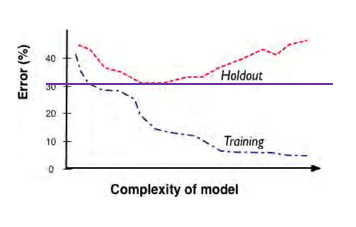

Image Source: Data Science For Business pg 114.